<a href="https://colab.research.google.com/github/aksoym/Machine-Learning/blob/master/AksoyMProject_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UUM625 Project 4

## Using CNN to detect aircraft existence in satellite images

### Prepared by Muhammet Aksoy



**Install modules and import libraries**

In [0]:
!pip3 install livelossplot

In [0]:
#Google drive libraries.
from google.colab import drive
drive.mount("/content/drive")

#Keras libraries.
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import models
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.metrics import binary_accuracy
from keras.utils import to_categorical
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from livelossplot import PlotLossesKeras
import tensorflow as tf
tf.random.set_random_seed(30)

#Numpy libraries.
import numpy as np
from numpy.random import shuffle
np.random.seed(30)

#Scikit-learn libraries.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#JSON to read .json files.
import json

#Matplotlib libraries.
import matplotlib.pyplot as plt


**Load the dataset(images) from .json format**

In [0]:
file = open("/content/drive/My Drive/DeepLearning/Project_4/planesnet.json")
planes = json.load(file)
file.close()

number_of_images = len(planes['data'])

print(planes.keys(), 
      "Number of images in the dataset: " + str(number_of_images), sep='\n')


dict_keys(['data', 'labels', 'locations', 'scene_ids'])
Number of images in the dataset: 32000


**Show a sample image from the dataset**

Aircraft existence: 1


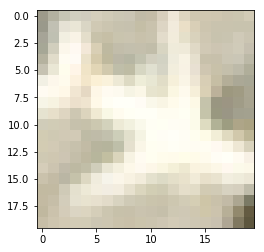

In [0]:
index = 500
sample_image = np.array(planes['data'][index]).astype('uint8') #Unsigned 8 bits means 256 possible integers to represent the RGB values.
sample_image = sample_image.reshape((3, 400)).T.reshape((20, 20, 3))

plt.imshow(sample_image)
print("Aircraft existence: " + str(planes['labels'][index]))
plt.show()

**Preparing images and labels**

In [0]:
#Convert each image data to 20, 20, 3 shape and create a list.
images = []
for i in range(len(planes['data'])):
  each_image = np.array(planes['data'][i]).astype('uint8') 
  each_image = each_image.reshape((3, 400)).T.reshape((20, 20, 3))
  images.append(each_image)

images = np.asarray(images)

#Labels list.
labels = planes['labels']
labels = np.asarray(labels)

print(images.shape, labels.shape, sep='\n')

(32000, 20, 20, 3)
(32000,)


**Train - Test split**

In [0]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, shuffle=True)


#Scaling the RGB values to have the range [0, 1].
train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255



**Convolutional Neural Network**

In [0]:
model = models.Sequential()


model.add(Conv2D(8, 2, padding='valid',input_shape=(20,20,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, 3, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, 2, kernel_initializer='random_uniform', padding='valid'))#64 2
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


opt = SGD(lr=0.01, momentum=0.1, decay=0.00005, nesterov=True)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 19, 19, 8)         104       
_________________________________________________________________
batch_normalization_43 (Batc (None, 19, 19, 8)         32        
_________________________________________________________________
activation_57 (Activation)   (None, 19, 19, 8)         0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 32)          2336      
_________________________________________________________________
batch_normalization_44 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
activation_58 (Activation)   (None, 7, 7, 32)          0         
__________

**Training**

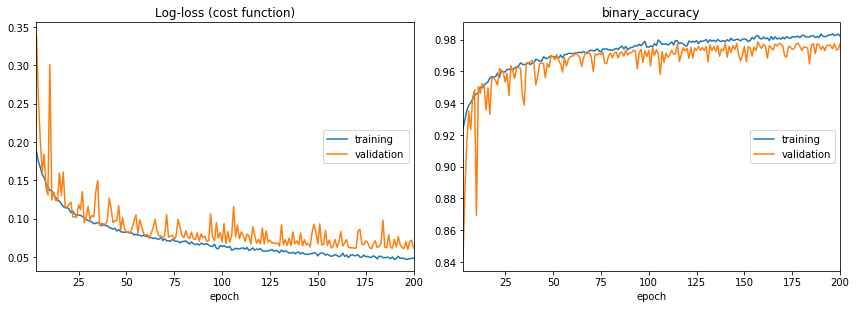

Log-loss (cost function):
training   (min:    0.047, max:    0.310, cur:    0.048)
validation (min:    0.059, max:    0.341, cur:    0.061)

binary_accuracy:
training   (min:    0.866, max:    0.984, cur:    0.982)
validation (min:    0.839, max:    0.979, cur:    0.978)


In [0]:
history = model.fit(train_images, train_labels, 
                    shuffle=True, validation_split=0.2,
                    batch_size=256, epochs=200, callbacks=[PlotLossesKeras()])

In [0]:
predicted_labels = model.predict(test_images)
predicted_labels[predicted_labels>0.5] = 1
predicted_labels[predicted_labels<0.5] = 0
print(classification_report(test_labels, predicted_labels),
      "Accuracy: " + str(accuracy_score(test_labels, predicted_labels)),
      confusion_matrix(test_labels, predicted_labels), sep='\n')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4778
           1       0.96      0.96      0.96      1622

    accuracy                           0.98      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.98      0.98      0.98      6400

Accuracy: 0.98046875
[[4718   60]
 [  65 1557]]
